# Amazon SageMaker Studio 
_**Using Gradient Boosted Trees for Mobile Banking Fraud Detection**_

## Contents

1. [Background](#Background) - Predict Banking Fraud Trannsaction with XGBoost
1. [Setup](#Setup) - Import all dependencies
1. [Data](#Data) - Download data from Kaggle and upload it sagemaker
1. [Exploration](#Exploration ) - Data Exploration. Explore the data to see the dataset's features and the data that will be used to train the model
1. [Feature Engineering](#Feature-Engineering) - Select Relevant Features
1. [Encoding](#Encoding) - One Hot Encoding for Categorical Data type, Transaction Type
1. [Train](#Train) - Split the lable data into Train, test, validate and upload files to S3. Then Train the Amazon SageMaker XGBoost algorithm
1. [Amazon SageMaker Experiments](#Experiments) - Create Experiments by changing one hyper parameter
1. [Amazon SageMaker Debugger](#Debugger) - Create Experiments by changing one hyper parameter
1. [Deploy the Model](#Deploy) Model is deploy it to a hosted endpoint.  Its configured to capture data that is being sent to the endpoint.
1. [Evaluation](#Evaluation) - Deployed model and check the accuracy using confusion matrix, precision and recall.  
1. [Verify Data in Amazon S3](#Verify) - Verify that all data related to inferencing requests sent are captured in Amazon S3 
1. [Realtime-Prediction](#Realtime-Prediction) - Rest service is exposed to client using AWS Lambda function and API Gateway
1. [Batch Transform](#Batch-Transform) -  Batch Transform inferencing


## Background

This project is part of the 2 Architecting For Machine Learning on Amazon SageMaker this 2-day workshop. Goal is to  quickly learn about the theory and application of machine learning for business application. 

* [Wrte up for this project](https://github.com/aws-samples/amazon-sagemaker-architecting-for-ml/blob/master/Writeups/Banking%20Fraud.md)
---


## Setup
Import all dependencies 

In [ ]:
import sys
!{sys.executable} -m pip install sagemaker -U
!{sys.executable} -m pip install sagemaker-experiments

In [ ]:
!{sys.executable} -m pip install sagemaker==1.72.0 -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import boto3
import re


import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig
from sagemaker.model_monitor import DataCaptureConfig, DatasetFormat, DefaultModelMonitor
from sagemaker.s3 import S3Uploader, S3Downloader

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [ ]:
# Session reference  : A session stores configuration state and allows us to create service clients and resources.
sess = boto3.Session()

# Service client instance for service name -sagemaker 
# To get all available services we can run  - sess.get_available_services()
sm = sess.client('sagemaker')

# Get the Amazon SageMaker Execution Role 
# It gives the execution role for the notebook instance. This is the IAM role that was created when we created our notebook instance. 
role = sagemaker.get_execution_role()

In [4]:
print("Session reference  : {}".format(sess))
print("Service Client : {}".format(sm))
print("SageMaker Execution Role  : {}".format(role))

Session reference  : Session(region_name='us-east-1')
Service Client : <botocore.client.SageMaker object at 0x7f157d556c10>
SageMaker Execution Role  : arn:aws:iam::807456629275:role/TeamRole


## Data 
Get data from Kaggle. This data is synteh
- Link https://www.kaggle.com/ntnu-testimon/paysim1

In [5]:
# Set the path we can find the data files that go with this notebook
%cd  /root/architecting-for-machine-learning
local_data_path = './data/training-dataset.csv'

df_fin_data = pd.read_csv(local_data_path)
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 10)         # Keep the output on one page

df_fin_data

/root/architecting-for-machine-learning


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## Exploration
 Data Exploration (Info from Kaggle)
 
 - We find that of the five types of transactions, fraud occurs only in two of them.
 - 'TRANSFER' where money is sent to a customer / fraudster and 
 - 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash.
 - The number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs

In [56]:
# Check Nulls
df_fin_data.isnull().values.any()

False

In [58]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df_fin_data.loc[df_fin_data.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df_fin_data.loc[(df_fin_data.isFraud == 1) & (df_fin_data.type == 'TRANSFER')]
dfFraudCashout = df_fin_data.loc[(df_fin_data.isFraud == 1) & (df_fin_data.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [27]:
# Frequency tables for each categorical feature
for column in df_fin_data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df_fin_data[column], columns='% observations', normalize='columns'))

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


col_0,% observations
type,
CASH_IN,0.219923
CASH_OUT,0.351663
DEBIT,0.006512
PAYMENT,0.338146
TRANSFER,0.083756


col_0,% observations
nameOrig,
C1000000639,1.571680e-07
C1000001337,1.571680e-07
C1000001725,1.571680e-07
C1000002591,1.571680e-07
C1000003372,1.571680e-07
...,...
C999996999,1.571680e-07
C999998175,1.571680e-07
C999999254,1.571680e-07


col_0,% observations
nameDest,
C1000004082,9.430078e-07
C1000004940,2.043183e-06
C1000013769,2.043183e-06
C100001587,1.414512e-06
C1000015936,2.514687e-06
...,...
M999998692,1.571680e-07
M99999900,1.571680e-07
M999999089,1.571680e-07


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


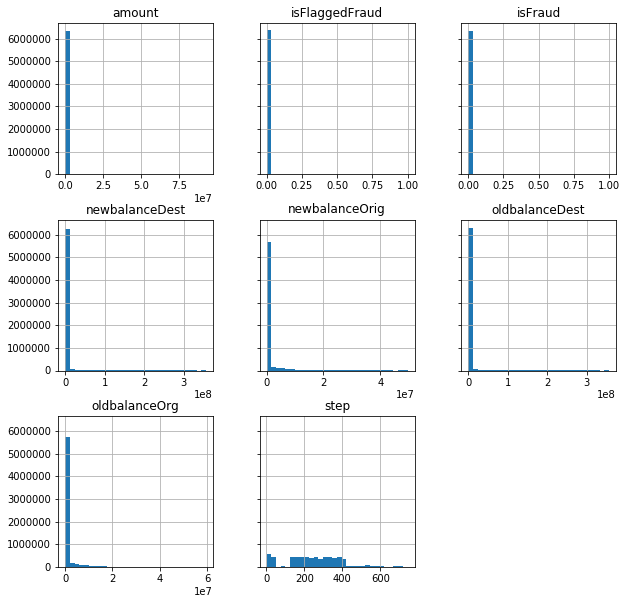

In [28]:
# Histograms for each numeric features
display(df_fin_data.describe())

%matplotlib inline
hist = df_fin_data.hist(bins=30, sharey=True, figsize=(10, 10))

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


isFraud,0,1
type,,
CASH_IN,0.220207,0.000000
CASH_OUT,0.351470,0.501157
DEBIT,0.006520,0.000000
PAYMENT,0.338583,0.000000
TRANSFER,0.083220,0.498843


step


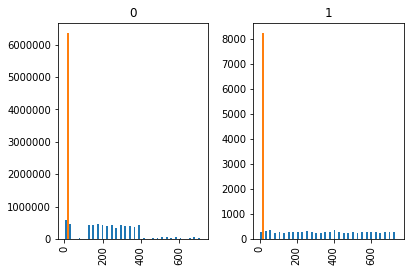

amount


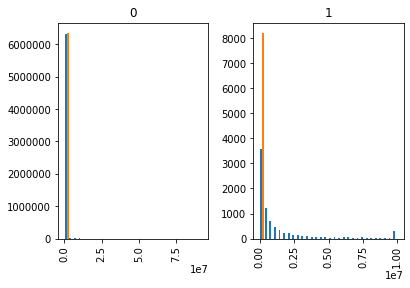

oldbalanceOrg


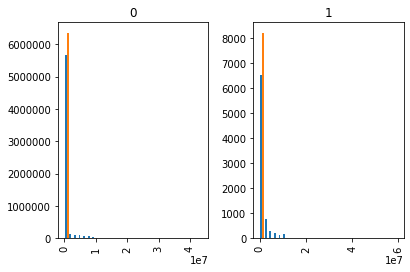

oldbalanceDest


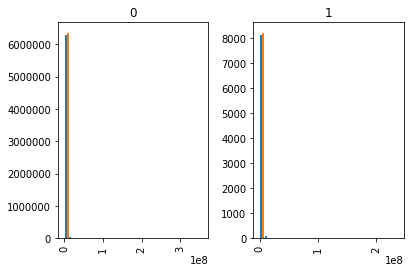

newbalanceDest


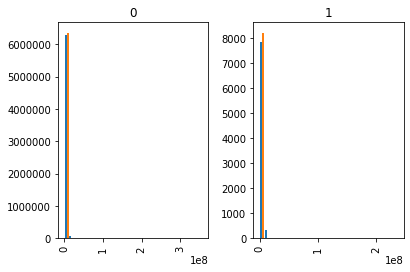

isFraud


ValueError: Grouper for 'isFraud' not 1-dimensional

In [60]:
#  relationship between each of the features and our target variable.
for column in df_fin_data.select_dtypes(include=['object']).columns:
    if column != 'isFraud':
        display(pd.crosstab(index=df_fin_data[column], columns=df_fin_data['isFraud'], normalize='columns'))

for column in df_fin_data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = df_fin_data[[column, 'isFraud']].hist(by='isFraud', bins=30)
    plt.show()

In [30]:
display(df_fin_data.corr())
#pd.plotting.scatter_matrix(df_fin_data, figsize=(12, 12))
#plt.show()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


## Feature-Engineering
Eliminate columns shown to be irrelevant

In [7]:
df_fin_data = df_fin_data.drop(['newbalanceOrig','nameOrig','nameDest','isFlaggedFraud'], axis=1)
df_fin_data.head(5)

,step,type,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,0.0,0.0,0


## Encoding 
One Hot encoding

In [8]:
model_data = pd.get_dummies(df_fin_data)

# Getting the label as first column
model_data = pd.concat([model_data['isFraud'], model_data.drop(['isFraud'], axis=1)], axis=1)
model_data.head(5)

,isFraud,step,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,1,9839.64,170136.0,0.0,0.0,0,0,0,1,0
1,0,1,1864.28,21249.0,0.0,0.0,0,0,0,1,0
2,1,1,181.00,181.0,0.0,0.0,0,0,0,0,1
3,1,1,181.00,181.0,21182.0,0.0,0,1,0,0,0
4,0,1,11668.14,41554.0,0.0,0.0,0,0,0,1,0


In [7]:
model_data.dtypes

isFraud             int64
step                int64
amount            float64
oldbalanceOrg     float64
oldbalanceDest    float64
                   ...   
type_CASH_IN        uint8
type_CASH_OUT       uint8
type_DEBIT          uint8
type_PAYMENT        uint8
type_TRANSFER       uint8
Length: 11, dtype: object

In [9]:
# Split the training data into train, validation and test
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])

#Save Train data to a csv fiile
train_data.to_csv('data/train.csv', header=False, index=False)

#Save Validation data to a csv fiile
validation_data.to_csv('data/validation.csv', header=False, index=False)

#Save Test data to a csv fiile
test_data.to_csv('data/test.csv', header=False, index=False)

In [10]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(4453834, 11)
(1272524, 11)
(636262, 11)


#### Now we'll upload the files to S3 for training but first we will create an S3 bucket for the data if one does not already exist.

In [11]:
account_id = sess.client('sts', region_name=sess.region_name).get_caller_identity()["Account"]
bucket = 'sagemaker-studio-{}-{}'.format(sess.region_name, account_id)
prefix = 'xgboost-fraud'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print("Looks like you already have a bucket of this name. That's good. Uploading the data files...")

# Return the URLs of the uploaded file, so they can be reviewed or used elsewhere
s3url = S3Uploader.upload('data/train.csv', 's3://{}/{}/{}'.format(bucket, prefix,'train'))
print("Training Data Bucket Name  : {}".format(s3url))

s3url = S3Uploader.upload('data/validation.csv', 's3://{}/{}/{}'.format(bucket, prefix,'validation'))
print("Validation Data Bucket Name  : {}".format(s3url))

s3url = S3Uploader.upload('data/test.csv', 's3://{}/{}/{}'.format(bucket, prefix,'test'))
print("Test Data Bucket Name  : {}".format(s3url))

Training Data Bucket Name  : s3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/train/train.csv
Validation Data Bucket Name  : s3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/validation/validation.csv
Test Data Bucket Name  : s3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/test/test.csv


---
## Train

We'll use the XGBoost library to train a class of models known as gradient boosted decision trees on the data that we just uploaded. 

Because we're using XGBoost, we first need to specify the locations of the XGBoost algorithm containers.

In [37]:
from sagemaker.amazon.amazon_estimator import get_image_uri
docker_image_name = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='0.90-2')
docker_image_name

	get_image_uri(region, 'xgboost', '1.0-1').


'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [13]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/test/'.format(bucket, prefix), content_type='csv')

# Print details of the s3_input
s3_input_train.config

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
   'S3Uri': 's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/train',
   'S3DataDistributionType': 'FullyReplicated'}},
 'ContentType': 'csv'}

## Experiments
Amazon SageMaker Experiments


In [41]:
sess = sagemaker.session.Session()

create_date = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
banking_fraud_experiment = Experiment.create(experiment_name="banking-fraud-xgboost-{}".format(create_date), 
                                              description="Using xgboost to predict banking fraud", 
                                              sagemaker_boto_client=boto3.client('sagemaker'))

banking_fraud_experiment

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f152d502d50>,experiment_name='banking-fraud-xgboost-2020-08-13-18-15-07',description='Using xgboost to predict banking fraud',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:807456629275:experiment/banking-fraud-xgboost-2020-08-13-18-15-07',response_metadata={'RequestId': 'c2c3a357-f4f5-4073-8497-37856a6dbf85', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c2c3a357-f4f5-4073-8497-37856a6dbf85', 'content-type': 'application/x-amz-json-1.1', 'content-length': '113', 'date': 'Thu, 13 Aug 2020 18:15:07 GMT'}, 'RetryAttempts': 0})

#### Hyperparameters
Now we can specify our XGBoost hyperparameters.  Among them are these key hyperparameters:
- `max_depth` Controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  Typically, you need to explore some trade-offs in model performance between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` Controls sampling of the training data.  This hyperparameter can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` Controls the number of boosting rounds.  This value specifies the models that are subsequently trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` Controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` Controls how aggressively trees are grown.  Larger values lead to more conservative models.
- `min_child_weight` Also controls how aggresively trees are grown. Large values lead to a more conservative model.

For more information about these hyperparameters, see [XGBoost's hyperparameters GitHub page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [42]:
hyperparams = {"max_depth":5,
               "subsample":0.8,
               "num_round":600,
               "eta":0.2,
               "gamma":4,
               "min_child_weight":6,
               "silent":0,
               "objective":'binary:logistic'}

#### Trial 1 - XGBoost in algorithm mode

For our first trial, we'll use the built-in XGBoost algorithm to train a model without supplying any additional code. This way, we can use XGBoost to train and deploy a model as we would with other Amazon SageMaker built-in algorithms.

We'll create a new `Trial` object and associate the trial with the experiment that we created earlier. To train the model, we'll create an estimator and specify a few parameters, like the type of training instances we'd like to use and how many, and where the artifacts of the trained model should be stored. 

We'll also associate the training job with the experiment trial that we just created when we call the `fit` method of the `estimator`.

In [ ]:
trial = Trial.create(trial_name="algorithm-mode-trial-{}".format(strftime("%Y-%m-%d-%H-%M-%S", gmtime())), 
                     experiment_name=banking_fraud_experiment.experiment_name,
                     sagemaker_boto_client=boto3.client('sagemaker'))

xgb = sagemaker.estimator.Estimator(image_name=docker_image_name,
                                    role=role,
                                    hyperparameters=hyperparams,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    base_job_name="demo-xgboost-banking-fraud",
                                    sagemaker_session=sess)

xgb.fit({'train': s3_input_train,
         'validation': s3_input_validation}, 
        experiment_config={
            "ExperimentName": banking_fraud_experiment.experiment_name, 
            "TrialName": trial.trial_name,
            "TrialComponentDisplayName": "Training",
        }
       )

INFO:sagemaker:Creating training-job with name: demo-xgboost-banking-fraud-2020-08-13-18-15-16-872


2020-08-13 18:15:17 Starting - Starting the training job...
2020-08-13 18:15:32 Starting - Launching requested ML instances.........
2020-08-13 18:16:50 Starting - Preparing the instances for training......
2020-08-13 18:17:51 Downloading - Downloading input data......
2020-08-13 18:19:10 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[18:19:15] 4453834x10 matrix with 44538340 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter

#### Trying other hyperparameter values

To improve a model, you typically try other hyperparameter values to see if they affect the final validation error. Let's vary the `min_child_weight` parameter and start other training jobs with those different values to see how they affect the validation error. For each value, we'll create a separate trial so that we can compare the results in Amazon SageMaker Studio later.

#### option: wait=False, Enables to run asynchronously 

In [24]:
min_child_weights = [1, 2, 4, 8, 10]

for weight in min_child_weights:
    hyperparams["min_child_weight"] = weight
    trial = Trial.create(trial_name="algorithm-mode-trial-{}-weight-{}".format(strftime("%Y-%m-%d-%H-%M-%S", gmtime()), weight), 
                         experiment_name=banking_fraud_experiment.experiment_name,
                         sagemaker_boto_client=boto3.client('sagemaker'))

    t_xgb = sagemaker.estimator.Estimator(image_name=docker_image_name,
                                          role=role,
                                          hyperparameters=hyperparams,
                                          train_instance_count=1, 
                                          train_instance_type='ml.m4.xlarge',
                                          output_path='s3://{}/{}/output'.format(bucket, prefix),
                                          base_job_name="demo-xgboost-banking-fraud",
                                          sagemaker_session=sess)

    t_xgb.fit({'train': s3_input_train,
               'validation': s3_input_validation},
                wait=False,
                experiment_config={
                    "ExperimentName": banking_fraud_experiment.experiment_name, 
                    "TrialName": trial.trial_name,
                    "TrialComponentDisplayName": "Training",
                }
               )

INFO:sagemaker:Creating training-job with name: demo-xgboost-banking-fraud-2020-08-13-10-01-55-118
INFO:sagemaker:Creating training-job with name: demo-xgboost-banking-fraud-2020-08-13-10-01-55-445
INFO:sagemaker:Creating training-job with name: demo-xgboost-banking-fraud-2020-08-13-10-01-57-877
INFO:sagemaker:Creating training-job with name: demo-xgboost-banking-fraud-2020-08-13-10-02-00-198
INFO:sagemaker:Creating training-job with name: demo-xgboost-banking-fraud-2020-08-13-10-02-01-357


#### Create charts

Create a chart, multi-select the components. We can create a scatter plot for the parameter sweep.


Since this is a sample training run and the data is sparse, there's not much to chart in a time series. However, we can create a scatter plot for the parameter sweep. The following screen shot for the scatter plot created at Trial Component Chart.



![scatter plot example](./images/chart.GIF)

### Debugger

Amazon SageMaker Debugger lets you debug a model during training. As you train, Debugger periodicially saves tensors, which fully specify the state of the model at that point in time. Debugger saves the tensors to an Amazon S3 bucket. You can then use Amazon SageMaker Studio for analysis and visualization to diagnose training issues.

#### Specify SageMaker Debugger Rules

To enable automated detection of common issues during training, Amazon SageMaker Debugger also allows you to attach a list of rules to evaluate the training job against.

Some rules that apply to XGBoost include `AllZero`, `ClassImbalance`, `Confusion`, `LossNotDecreasing`, `Overfit`, `Overtraining`, `SimilarAcrossRuns`, `TensorVariance`, `UnchangedTensor`, and `TreeDepth`. 

We'll use the `LossNotDecreasing` rule--which is triggered if the loss doesn't decrease monotonically at any point during training--the `Overtraining` rule, and the `Overfit` rule. Let's create the rules.

In [25]:
debug_rules = [Rule.sagemaker(rule_configs.loss_not_decreasing()),
               Rule.sagemaker(rule_configs.overtraining()),
               Rule.sagemaker(rule_configs.overfit())
              ]

---
## Deploy

Now that we've trained the model, let's deploy it to a hosted endpoint. To monitor the model after it's hosted and serving requests, we'll also add configurations to capture data that is being sent to the endpoint.

In [45]:
data_capture_prefix = '{}/datacapture'.format(prefix)

endpoint_name = "demo-xgboost-banking-fraud-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName = {}".format(endpoint_name))

EndpointName = demo-xgboost-banking-fraud-2020-08-13-19-51-38


In [46]:
xgb_predictor = xgb.deploy(initial_instance_count=1, 
                           instance_type='ml.m4.xlarge',
                           endpoint_name=endpoint_name,
                           data_capture_config=DataCaptureConfig(enable_capture=True,
                                                                 sampling_percentage=100,
                                                                 destination_s3_uri='s3://{}/{}'.format(bucket, data_capture_prefix)
                                                                )
                           )

INFO:sagemaker:Creating model with name: demo-xgboost-banking-fraud-2020-08-13-18-15-16-872
INFO:sagemaker:Creating endpoint with name demo-xgboost-banking-fraud-2020-08-13-19-51-38


-----------------!

In [47]:
endpoint_name

'demo-xgboost-banking-fraud-2020-08-13-19-51-38'

## Evaluation
### Invoke the deployed model and check the accuracy using confusion matrix, precision and recall    

Now that we have a hosted endpoint running, we can make real-time predictions from our model by making an http POST request.  But first, we need to set up serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [48]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll loop over our test dataset and collect predictions by invoking the XGBoost endpoint:

In [49]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [50]:
# Sample Test data
 
x = test_data.to_numpy()[:,1:]
#np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

predictions = predict(x)

predictions

array([2.97875169e-09, 4.24428159e-10, 1.05880050e-03, ...,
       8.46763770e-11, 7.46147543e-06, 1.37072419e-07])

In [36]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,635419,16
1,164,663


In [76]:
TP = 635419
FP = 16
FN  = 164
TN = 663

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy  : {}".format(ACC))

Overall accuracy  : 0.9997170976735998


In [67]:
np.round(predictions)

array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
test_data.head(5)

,isFraud,step,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
649918,0,35,132520.80,11508.00,0.00,0.00,1,0,0,0,0
6078014,0,518,5927.64,58852.27,0.00,0.00,0,0,0,1,0
3352247,0,253,2899.46,6054.00,964608.59,967508.05,0,1,0,0,0
2875453,0,227,193469.02,0.00,248357.55,441826.56,0,1,0,0,0
5729113,0,399,93088.86,107246.00,0.00,93088.86,0,1,0,0,0


In [39]:
## All the request are captured because thats how we have configured , to capture data we have in deploy step -  enable_capture=True,

print("Sending test traffic to the endpoint {}. \nPlease wait for a minute...".format(endpoint_name))

with open('data/test-sample.csv', 'r') as f:
    for row in f:
        payload = row.rstrip('\n')
        response = xgb_predictor.predict(data=payload)
        time.sleep(0.5)

Sending test traffic to the endpoint demo-xgboost-banking-fraud-2020-08-13-08-20-13. 
Please wait for a minute...


## Verify
#### Verify that data is captured in Amazon S3

When we made some real-time predictions by sending data to our endpoint, we should have also captured that data for monitoring purposes. 

Let's list the data capture files stored in Amazon S3. Expect to see different files from different time periods organized based on the hour in which the invocation occurred. The format of the Amazon S3 path is:

`s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`

In [40]:
from time import sleep

current_endpoint_capture_prefix = '{}/{}'.format(data_capture_prefix, endpoint_name)
for _ in range(12): # wait up to a minute to see captures in S3
    capture_files = S3Downloader.list("s3://{}/{}".format(bucket, current_endpoint_capture_prefix))
    if capture_files:
        break
    sleep(5)

print("Found Data Capture Files:")
print(capture_files)

Found Data Capture Files:
['s3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/datacapture/demo-xgboost-banking-fraud-2020-08-13-08-20-13/AllTraffic/2020/08/13/08/49-54-851-b4e48b46-e1be-4028-a892-84df793d2db1.jsonl', 's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/datacapture/demo-xgboost-banking-fraud-2020-08-13-08-20-13/AllTraffic/2020/08/13/08/50-03-914-0eebb213-4efd-4a11-8c70-3af08a2dfeba.jsonl', 's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/datacapture/demo-xgboost-banking-fraud-2020-08-13-08-20-13/AllTraffic/2020/08/13/08/50-12-198-ad03b7d4-f361-4df2-842a-29be412ccb10.jsonl', 's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/datacapture/demo-xgboost-banking-fraud-2020-08-13-08-20-13/AllTraffic/2020/08/13/08/50-20-194-f42c5f0d-32a6-4b7b-acff-c9dd3556a255.jsonl', 's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/datacapture/demo-xgboost-banking-fraud-2020-08-13-08-20-13/AllTraffic/2020/08/13/08/50-28-217-e5af893b-92c0-4aa7-835e

In [45]:
capture_file = S3Downloader.read_file(capture_files[-1])

print("=====Single Data Capture====")
print(json.dumps(json.loads(capture_file.split('\n')[0]), indent=2)[:4000])

=====Single Data Capture====
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "35,132520.8,11508,0,0,1,0,0,0,0",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "2.978751689752812e-09",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "af9f2c5f-5e7a-4c79-bc5e-e76cda6c67d2",
    "inferenceTime": "2020-08-13T09:05:58Z"
  },
  "eventVersion": "0"
}


## Realtime-Prediction
#### Create Realtime Inferencing
 

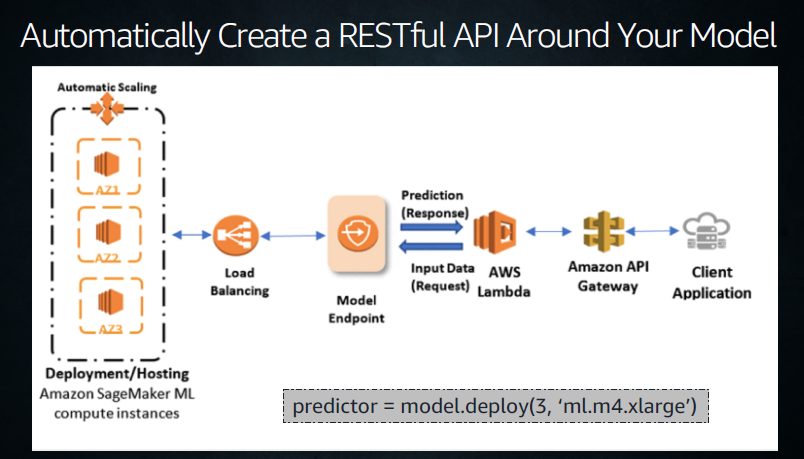

- REST Service created -  https://rbfpcggsk2.execute-api.us-east-1.amazonaws.com/test/predictionxgboost

- Screen print of Postman

 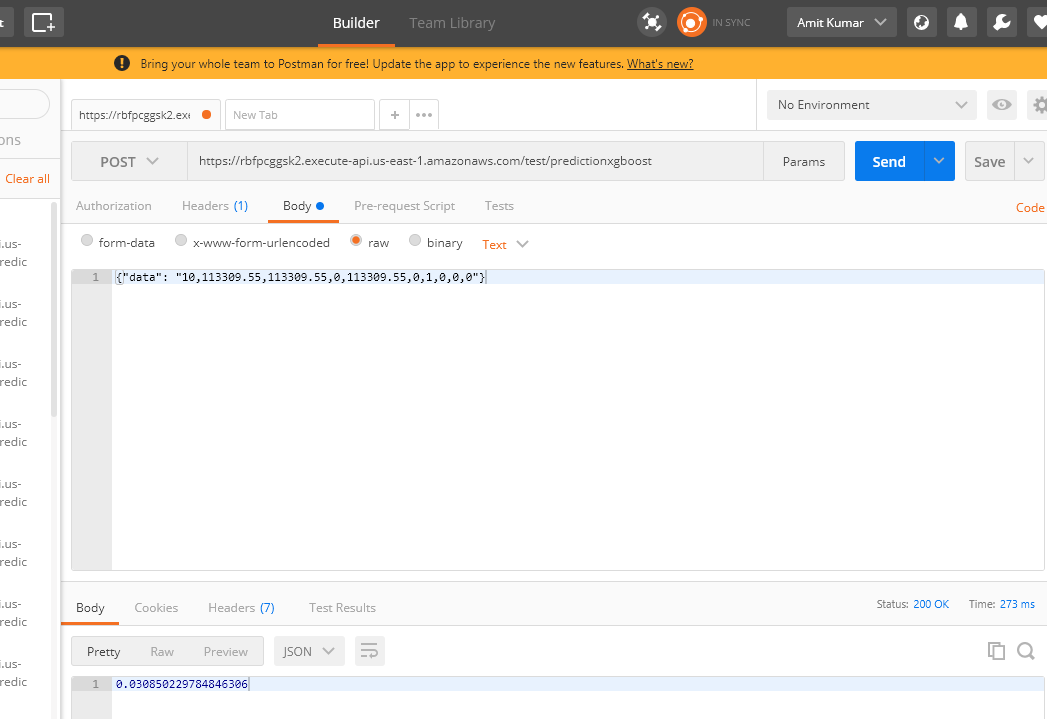

## Batch-Transform
#### Get Inferences for an Batch Dataset with Batch Transform

In [55]:
# The location of the test dataset
batch_input = 's3://{}/{}/batch-load/'.format(bucket, prefix)

# The location to store the results of the batch transform job
batch_output = 's3://{}/{}/batch-inference'.format(bucket, prefix)

transformer = xgb.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

transformer.wait()

INFO:sagemaker:Creating model with name: demo-xgboost-banking-fraud-2020-08-13-18-15-16-872
INFO:sagemaker:Creating transform job with name: demo-xgboost-banking-fraud-2020-08-13-20-31-15-097


..................................2020-08-13T20:36:49.017:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2020-08-13:20:36:46:INFO] No GPUs detected (normal if no gpus installed)
[2020-08-13:20:36:46:INFO] No GPUs detected (normal if no gpus installed)
[2020-08-13:20:36:46:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http

In [34]:

batch_input

's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/test/'

In [35]:
batch_output = 's3://{}/{}/batch-inference'.format(bucket, prefix)
batch_output

's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/batch-inference'

As you can see, each inference request is captured in one line in the jsonl file. The line contains both the input and output merged together. In our example, we provided the ContentType as `text/csv` which is reflected in the `observedContentType` value. Also, we expose the enconding that we used to encode the input and output payloads in the capture format with the `encoding` value.

To recap, we have observed how you can enable capturing the input and/or output payloads to an Endpoint with a new parameter. We have also observed how the captured format looks like in S3. Let's continue to explore how SageMaker helps with monitoring the data collected in S3.

---
## Amazon SageMaker Model Monitor

Amazon SageMaker Model Monitor lets you monitor and evaluate the data observed by endpoints. It works like this:
1. We need to create a baseline that we can use to compare real-time traffic against. 
1. When a baseline is ready, we can set up a schedule to continously evaluate and compare against the baseline.
1. We can send synthetic traffic to trigger alarms.

**Important**: It takes an hour or more to complete this section because the shortest monitoring polling time is one hour. The following graphic shows how the monitoring results look after running for a few hours and some of the errors triggered by synthetic traffic.

### Baselining and continous monitoring

#### 1. Constraint suggestion with the baseline (training) dataset

The training dataset that you use to train a model is usually a good baseline dataset. Note that the training dataset data schema and the inference dataset schema must match exactly (for example, they should have the same number and type of features).

Using our training dataset, let's ask Amazon SageMaker Model Monitor to suggest a set of baseline `constraints` and generate descriptive `statistics` so we can explore the data. For this example, let's upload the training dataset, which we used to train model. We'll use the dataset file with column headers so we have descriptive feature names.

In [46]:
baseline_prefix = prefix + '/baselining'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(bucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(bucket, baseline_results_prefix)
print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))
baseline_data_path = S3Uploader.upload("data/training-dataset.csv", baseline_data_uri)

Baseline data uri: s3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/baselining/data
Baseline results uri: s3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/baselining/results


##### Create a baselining job with the training dataset

Now that we have the training data ready in S3, let's start a job to `suggest` constraints. To generate the constraints, the convenient helper starts a `ProcessingJob` using a ProcessingJob container provided by Amazon SageMaker.

In [47]:
my_default_monitor = DefaultModelMonitor(role=role,
                                         instance_count=1,
                                         instance_type='ml.m5.xlarge',
                                         volume_size_in_gb=20,
                                         max_runtime_in_seconds=3600,
                                        )

baseline_job = my_default_monitor.suggest_baseline(baseline_dataset=baseline_data_path,
                                                   dataset_format=DatasetFormat.csv(header=True),
                                                   output_s3_uri=baseline_results_uri,
                                                   wait=True
)

INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2020-08-13-09-11-16-555



Job Name:  baseline-suggestion-job-2020-08-13-09-11-16-555
Inputs:  [{'InputName': 'baseline_dataset_input', 'S3Input': {'S3Uri': 's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/baselining/data/training-dataset.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'S3Output': {'S3Uri': 's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
........................2020-08-13 09:15:07,977 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:us-east-1:807456629275:processing-job/baseline-suggestion-job-2020-08-13-09-11-16-555', 'ProcessingJobName': 'baseline-suggestion-job-2020-08-13-09-11-16-555', 'Environment': {'dataset_format': '{"csv": {"header": true, "output_columns_posi

Once the job succeeds, we can explore the `baseline_results_uri` location in s3 to see what files where stored there.

In [48]:
print("Found Files:")
S3Downloader.list("s3://{}/{}".format(bucket, baseline_results_prefix))

Found Files:


['s3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/baselining/results/constraints.json',
 's3://sagemaker-studio-us-east-1-807456629275/xgboost-fraud/baselining/results/statistics.json']

We have a`constraints.json` file that has information about suggested constraints. We also have a `statistics.json` which contains statistical information about the data in the baseline.

In [49]:
baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data,string_statistics.common.num_present,string_statistics.common.num_missing,string_statistics.distinct_count,string_statistics.distribution.categorical.buckets
0,step,Integral,6362620.0,0.0,243.397246,1.548644e+09,142.331960,1.0,743.0,"[{'lower_bound': 1.0, 'upper_bound': 75.2, 'co...",0.64,2048.0,"[[716.0, 716.0, 716.0, 716.0, 716.0, 716.0, 71...",NaN,NaN,NaN,NaN
1,type,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6362620.0,0.0,5.0,"[{'value': 'TRANSFER', 'count': 532909}, {'val..."
2,amount,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6362620.0,0.0,5017748.0,NaN
3,nameOrig,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6362620.0,0.0,6237763.0,NaN
4,oldbalanceOrg,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6362620.0,0.0,1907269.0,NaN
5,newbalanceOrig,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6362620.0,0.0,2767397.0,NaN
6,nameDest,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6362620.0,0.0,2783724.0,NaN
7,oldbalanceDest,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6362620.0,0.0,3709283.0,NaN
8,newbalanceDest,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6362620.0,0.0,3828281.0,NaN
9,isFraud,Integral,6362620.0,0.0,0.001291,8.213000e+03,0.035905,0.0,1.0,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN,NaN,NaN


In [50]:
constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,name,inferred_type,completeness,num_constraints.is_non_negative,string_constraints.domains
0,step,Integral,1.0,True,NaN
1,type,String,1.0,NaN,"[TRANSFER, DEBIT, CASH_IN, CASH_OUT, PAYMENT]"
2,amount,String,1.0,NaN,NaN
3,nameOrig,String,1.0,NaN,NaN
4,oldbalanceOrg,String,1.0,NaN,NaN
5,newbalanceOrig,String,1.0,NaN,NaN
6,nameDest,String,1.0,NaN,NaN
7,oldbalanceDest,String,1.0,NaN,NaN
8,newbalanceDest,String,1.0,NaN,NaN
9,isFraud,Integral,1.0,True,NaN


#### 2. Analyzing subsequent captures for data quality issues

Now that we've generated a baseline dataset and processed it to get baseline statistics and constraints, let's monitor and analyze the data being sent to the endpoint with monitoring schedules.

##### Create a schedule
First, let's create a monitoring schedule for the endpoint. The schedule specifies the cadence at which we want to run a new processing job so that we can compare recent data captures to the baseline.

In [51]:
# First, copy over some test scripts to the S3 bucket so that they can be used for pre and post processing
code_prefix = '{}/code'.format(prefix)
pre_processor_script = S3Uploader.upload('preprocessor.py', 's3://{}/{}'.format(bucket,code_prefix))
s3_code_postprocessor_uri = S3Uploader.upload('postprocessor.py', 's3://{}/{}'.format(bucket,code_prefix))

We are ready to create a model monitoring schedule for the Endpoint created before and also the baseline resources (constraints and statistics) which were generated above.

In [52]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

reports_prefix = '{}/reports'.format(prefix)
s3_report_path = 's3://{}/{}'.format(bucket,reports_prefix)

mon_schedule_name = 'demo-xgboost-customer-churn-model-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
my_default_monitor.create_monitoring_schedule(monitor_schedule_name=mon_schedule_name,
                                              endpoint_input=xgb_predictor.endpoint,
                                              #record_preprocessor_script=pre_processor_script,
                                              post_analytics_processor_script=s3_code_postprocessor_uri,
                                              output_s3_uri=s3_report_path,
                                              statistics=my_default_monitor.baseline_statistics(),
                                              constraints=my_default_monitor.suggested_constraints(),
                                              schedule_cron_expression=CronExpressionGenerator.hourly(),
                                              enable_cloudwatch_metrics=True,
                                             )

INFO:sagemaker:Creating monitoring schedule name demo-xgboost-customer-churn-model-schedule-2020-08-13-09-44-59.



Creating Monitoring Schedule with name: demo-xgboost-customer-churn-model-schedule-2020-08-13-09-44-59


#### 3. Start generating some artificial traffic
The following block starts a thread to send some traffic to the endpoint. This allows us to continue to send traffic to the endpoint so that we'll have data continually captured for analysis. If there is no traffic, the monitoring jobs will start to fail later.

To terminate this thread, you need to stop the kernel.

In [54]:
from threading import Thread

runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                          ContentType='text/csv', 
                                          Body=payload)
            response['Body'].read()
            sleep(1)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(endpoint_name, 'data/test-sample.csv', runtime_client)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()

# Note that you need to stop the kernel to stop the invocations

##### List executions
Once the schedule is set up, jobs start at the specified intervals. The following code lists the last five executions. If you run this code soon after creating the hourly schedule, you might not see any executions listed. To see executions, you might have to wait until you cross the hour boundary (in UTC). The code includes the logic for waiting.

In [55]:
mon_executions = my_default_monitor.list_executions()
if len(mon_executions) == 0:
    print("We created a hourly schedule above and it will kick off executions ON the hour.\nWe will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = my_default_monitor.list_executions()  

No executions found for schedule. monitoring_schedule_name: demo-xgboost-customer-churn-model-schedule-2020-08-13-09-44-59
We created a hourly schedule above and it will kick off executions ON the hour.
We will have to wait till we hit the hour...
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: demo-xgboost-customer-churn-model-schedule-2020-08-13-09-44-59
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: demo-xgboost-customer-churn-model-schedule-2020-08-13-09-44-59
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: demo-xgboost-customer-churn-model-schedule-2020-08-13-09-44-59
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: demo-xgboost-customer-churn-model-schedule-2020-08-13-09-44-59
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_

KeyboardInterrupt: 

##### Evaluate the latest execution and list the generated reports

In [ ]:
latest_execution = mon_executions[-1]
latest_execution.wait()

In [ ]:
print("Latest execution result: {}".format(latest_execution.describe()['ExitMessage']))
report_uri = latest_execution.output.destination

print("Found Report Files:")
S3Downloader.list(report_uri)

##### List violations

If there are any violations compared to the baseline, they will be generated here. Let's list the violations.

In [ ]:
violations = my_default_monitor.latest_monitoring_constraint_violations()
pd.set_option('display.max_colwidth', -1)
constraints_df = pd.io.json.json_normalize(violations.body_dict["violations"])
constraints_df.head(10)

You can plug in the processing job arn for a single execution of the monitoring into [this notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/visualization/SageMaker-Model-Monitor-Visualize.ipynb) to see more detailed visualizations of the violations and distribution statistics of the data captue that was processed in that execution


In [ ]:
latest_execution.describe()['ProcessingJobArn']